In [1]:
import pandas as pd
import h2o
from h2o.estimators import H2ORandomForestEstimator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Load data

In [2]:
df = pd.read_csv("preped_churn_data.csv")

df.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_MonthlyCharges_ratio,customerID
1198,42,Yes,Two year,Bank transfer (automatic),20.75,844.45,No,40.696386,1199
5028,72,Yes,Two year,Electronic check,109.90,7624.20,No,69.373976,5029
1532,14,Yes,Month-to-month,Credit card (automatic),19.60,300.40,No,15.326531,1533
83,42,Yes,Month-to-month,Bank transfer (automatic),103.80,4327.50,No,41.690751,84
4003,38,Yes,Two year,Mailed check,20.30,743.05,No,36.603448,4004
1681,72,Yes,Two year,Credit card (automatic),25.00,1849.20,No,73.968000,1682
879,33,Yes,Month-to-month,Bank transfer (automatic),54.65,1665.20,No,30.470265,880
2921,9,Yes,Month-to-month,Electronic check,95.50,829.10,Yes,8.681675,2922
5185,50,Yes,One year,Credit card (automatic),70.80,3478.15,No,49.126412,5186
1257,45,No,One year,Electronic check,34.20,1596.60,No,46.684211,1258


In [3]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_MonthlyCharges_ratio,customerID
0,1,0,Month-to-month,Electronic check,29.85,29.85,0,1.000000,1
1,34,1,One year,Mailed check,56.95,1889.50,0,33.178227,2
2,2,1,Month-to-month,Mailed check,53.85,108.15,1,2.008357,3
3,45,0,One year,Bank transfer (automatic),42.30,1840.75,0,43.516548,4
4,2,1,Month-to-month,Electronic check,70.70,151.65,1,2.144979,5
...,...,...,...,...,...,...,...,...,...
7038,24,1,One year,Mailed check,84.80,1990.50,0,23.472877,7039
7039,72,1,One year,Credit card (automatic),103.20,7362.90,0,71.345930,7040
7040,11,0,Month-to-month,Electronic check,29.60,346.45,0,11.704392,7041
7041,4,1,Month-to-month,Mailed check,74.40,306.60,1,4.120968,7042


In [4]:
PM_dummies = pd.get_dummies(df['PaymentMethod'], prefix='PaymentMethod')
C_dummies = pd.get_dummies(df['Contract'], prefix='Contract')

df = pd.concat([df, PM_dummies, C_dummies], axis=1)

df = df.loc[:, ~df.columns.duplicated()]

df.head(5)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_MonthlyCharges_ratio,customerID,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
0,1,0,Month-to-month,Electronic check,29.85,29.85,0,1.000000,1,False,False,True,False,True,False,False
1,34,1,One year,Mailed check,56.95,1889.50,0,33.178227,2,False,False,False,True,False,True,False
2,2,1,Month-to-month,Mailed check,53.85,108.15,1,2.008357,3,False,False,False,True,True,False,False
3,45,0,One year,Bank transfer (automatic),42.30,1840.75,0,43.516548,4,True,False,False,False,False,True,False
4,2,1,Month-to-month,Electronic check,70.70,151.65,1,2.144979,5,False,False,True,False,True,False,False


In [5]:
dummies = ['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'PaymentMethod_Credit card (automatic)']

for column in dummies:
    df[column] = pd.factorize(df[column])[0]

df.sample(5)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_MonthlyCharges_ratio,customerID,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
5246,2,1,Month-to-month,Electronic check,79.75,164.50,1,2.062696,5247,0,0,0,0,0,0,0
3896,38,1,One year,Mailed check,20.30,749.35,0,36.913793,3897,0,0,1,1,1,1,0
5493,6,1,Month-to-month,Electronic check,84.35,474.90,1,5.630113,5494,0,0,0,0,0,0,0
2498,27,1,Month-to-month,Electronic check,53.80,1389.85,0,25.833643,2499,0,0,0,0,0,0,0
3552,68,1,Two year,Bank transfer (automatic),102.10,7149.35,0,70.023017,3553,1,0,1,0,1,0,1


In [6]:
df = df.drop(['PaymentMethod', 'Contract', 'customerID'], axis=1)
df

,tenure,PhoneService,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_MonthlyCharges_ratio,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
0,1,0,29.85,29.85,0,1.000000,0,0,0,0,0,0,0
1,34,1,56.95,1889.50,0,33.178227,0,0,1,1,1,1,0
2,2,1,53.85,108.15,1,2.008357,0,0,1,1,0,0,0
3,45,0,42.30,1840.75,0,43.516548,1,0,1,0,1,1,0
4,2,1,70.70,151.65,1,2.144979,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1,84.80,1990.50,0,23.472877,0,0,1,1,1,1,0
7039,72,1,103.20,7362.90,0,71.345930,0,1,1,0,1,1,0
7040,11,0,29.60,346.45,0,11.704392,0,0,0,0,0,0,0
7041,4,1,74.40,306.60,1,4.120968,0,0,1,1,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   int64  
 1   PhoneService                             7043 non-null   int64  
 2   MonthlyCharges                           7043 non-null   float64
 3   TotalCharges                             7043 non-null   float64
 4   Churn                                    7043 non-null   int64  
 5   TotalCharges_to_MonthlyCharges_ratio     7043 non-null   float64
 6   PaymentMethod_Bank transfer (automatic)  7043 non-null   int64  
 7   PaymentMethod_Credit card (automatic)    7043 non-null   int64  
 8   PaymentMethod_Electronic check           7043 non-null   int64  
 9   PaymentMethod_Mailed check               7043 non-null   int64  
 10  Contract_Month-to-month                  7043 no

In [8]:
df.isna().sum()

tenure                                     0
PhoneService                               0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
TotalCharges_to_MonthlyCharges_ratio       0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
Contract_Month-to-month                    0
Contract_One year                          0
Contract_Two year                          0
dtype: int64

## Split into features and targets

In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']

## Split nto training and test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit and plot the DT

In [11]:
dt_model = DecisionTreeClassifier(max_depth=5)  
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [12]:
tr= export_text(dt_model, feature_names=list(X.columns))
print(tr)

|--- Contract_Month-to-month <= 0.50
|   |--- MonthlyCharges <= 68.62
|   |   |--- TotalCharges_to_MonthlyCharges_ratio <= 3.75
|   |   |   |--- MonthlyCharges <= 20.88
|   |   |   |   |--- TotalCharges <= 20.57
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TotalCharges >  20.57
|   |   |   |   |   |--- class: 0
|   |   |   |--- MonthlyCharges >  20.88
|   |   |   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- TotalCharges_to_MonthlyCharges_ratio >  3.75
|   |   |   |--- PhoneService <= 0.50
|   |   |   |   |--- TotalCharges <= 330.30
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TotalCharges >  330.30
|   |   |   |   |   |--- class: 0
|   |   |   |--- PhoneService >  0.50
|   |   |   |   |--- TotalCharges_to_MonthlyCharges_ratio <= 17.79
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TotalCharges_to_MonthlyCharges_ratio

## Hyperparameter tuning

In [13]:
param_grid = {'max_depth': [3, 5, 7, 10]} 
dt_model = DecisionTreeClassifier()
grid_search = GridSearchCV(dt_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10]})

## Bests max_depth

In [14]:
best_max_depth = grid_search.best_params_['max_depth']
best_max_depth

3

## Fit and plot DT with best hyperparameters

In [15]:
dt_model_tuned = DecisionTreeClassifier(max_depth=best_max_depth)
dt_model_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [16]:
tr_tuned = export_text(dt_model_tuned, feature_names=list(X.columns))
print(tr_tuned)

|--- Contract_Month-to-month <= 0.50
|   |--- MonthlyCharges <= 68.62
|   |   |--- TotalCharges_to_MonthlyCharges_ratio <= 3.75
|   |   |   |--- class: 0
|   |   |--- TotalCharges_to_MonthlyCharges_ratio >  3.75
|   |   |   |--- class: 0
|   |--- MonthlyCharges >  68.62
|   |   |--- TotalCharges_to_MonthlyCharges_ratio <= 13.16
|   |   |   |--- class: 1
|   |   |--- TotalCharges_to_MonthlyCharges_ratio >  13.16
|   |   |   |--- class: 0
|--- Contract_Month-to-month >  0.50
|   |--- MonthlyCharges <= 93.67
|   |   |--- Contract_Two year <= 0.50
|   |   |   |--- class: 0
|   |   |--- Contract_Two year >  0.50
|   |   |   |--- class: 0
|   |--- MonthlyCharges >  93.67
|   |   |--- TotalCharges_to_MonthlyCharges_ratio <= 70.35
|   |   |   |--- class: 0
|   |   |--- TotalCharges_to_MonthlyCharges_ratio >  70.35
|   |   |   |--- class: 0



After hyperparameter tuning, the decision tree with the best_max_depth of 3 provides a more detailed view of potential predictors for customer churn. The tree structure indicates that customers with shorter month-to-month contract durations, lower monthly charges, and specific ratios of charges are more likely to churn (class: 1). Additionally, the tree introduces new conditions, such as the tenure-related features, total charges, and payment methods, providing a more granular understanding of customer behavior.

## Correlataions between features and targets

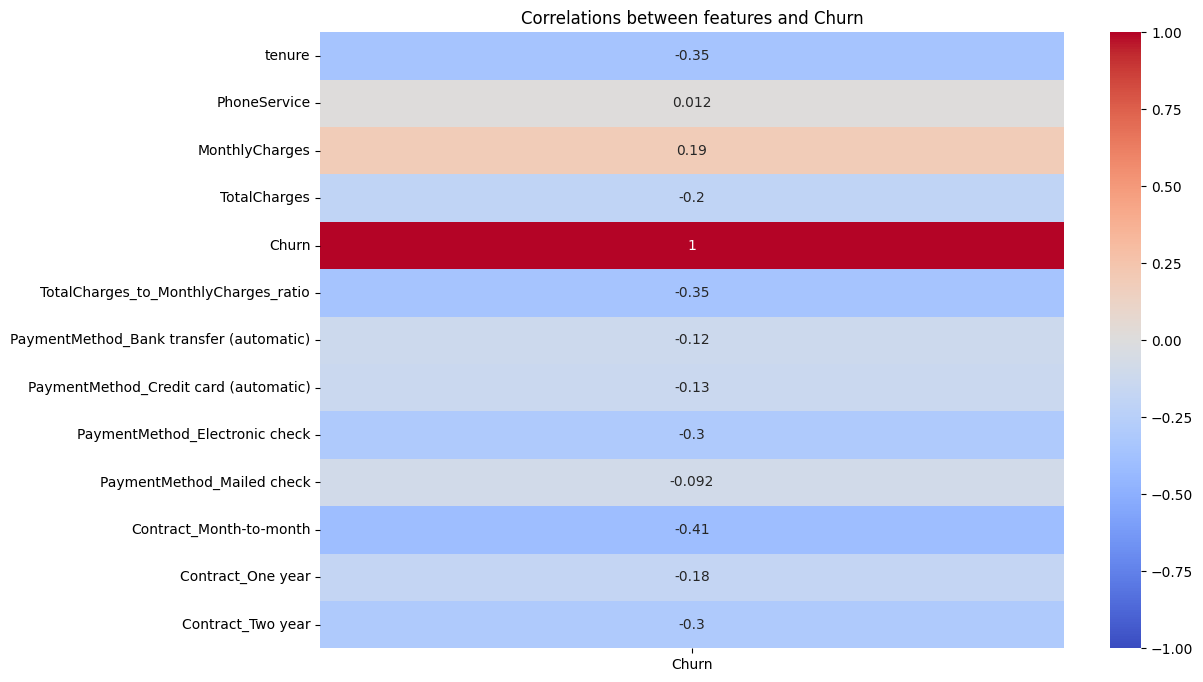

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr()[['Churn']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlations between features and Churn")
plt.show()

## Using h2o cluster

In [ ]:
h2o.init()

In [19]:
hf = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [20]:
train, test = hf.split_frame(ratios=[0.8], seed=42)

## Fit h2o Random Forest

In [21]:
rf_h2o = H2ORandomForestEstimator(seed=42)
rf_h2o.train(x=hf.columns[:-1], y="Churn", training_frame=train)

drf Model Build progress: |

/home/sensei/.local/lib/python3.11/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1707690266499_3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          559013                 20           20           20            677           949           884.36

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.15774412810130986
RMSE: 0.3971701500633071
MAE: 0.2686530996248829
RMSLE: 0.2795712145057003
Mean Residual Deviance: 0.15774412810130986

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2024-02-12 02:10:03  0.010 sec   0.0                nan                  nan                  nan
     2024-02-12 02:10:03  0.070 sec   1.0                0.5154630062894613   0.27579260292488367  0.2657021108529692
     2024-02-12 02:10:03  0.091 sec   2.0                0.4979091988363233   0.268514992629594    0.2479135702858293
     2024-02-12 02:10:03  0.113 sec   3.0                0.48250070455236443  0.26628261689312005  0.23280692989352805
     2024-02-12 02:10:03  0.135 sec   4.0                0.4782295541855733   0.2703415020837108   0.22870350649653218
     2024-02-12 02:10:03  0.156 sec   5.0                0.4659625520665139   0.26851994370601157  0.21712109992833867
     2024-02-12 02:10:03  0.178 sec   6.0                0.4575545957450176   0.2688221898486882   0.2093562080873865
     2024-02-12 02:10:03  0.202 sec   7.0                0.4479999497764946   0.267086238085245    0.20070395499974167
     2024-02-12 02:10:03  0.240 sec   8.0                0.44251409827928573  0.2674692008569007   0.19581872717592935
     2024-02-12 02:10:04  1.421 sec   9.0                0.4381472979392279   0.267797891914376    0.19197305469144654
---  ---                  ---         ---                ---                  ---                  ---
     2024-02-12 02:10:06  2.708 sec   41.0               0.39935892278663687  0.268884164293669    0.159487549209303
     2024-02-12 02:10:06  2.751 sec   42.0               0.3992773836700508   0.2689012220193489   0.15942242911040092
     2024-02-12 02:10:06  2.796 sec   43.0               0.3988916311520161   0.2688496596505218   0.15911453340311607
     2024-02-12 02:10:06  2.860 sec   44.0               0.3984211642320937   0.2687127707105981   0.158739424108057
     2024-02-12 02:10:06  2.912 sec   45.0               0.3980857181538183   0.2685123453935268   0.15847223899804128
     2024-02-12 02:10:06  2.963 sec   46.0               0.3981268443054598   0.26873277255738004  0.15850498415662384
     2024-02-12 02:10:06  3.018 sec   47.0               0.39801876186829677  0.2687787162816915   0.1584189347991719
     2024-02-12 02:10:06  3.058 sec   48.0               0.39757195988590244  0.2686759987031235   0.15806346328751764
     2024-02-12 02:10:06  3.104 sec   49.0               0.3974260781670253   0.26876258939016195  0.15794748760722252
     2024-02-12 02:10:06  3.154 sec   50.0               0.3971701500633071   0.2686530996248829   0.15774412810130986
[51 rows x 7 columns]


Variable Importances: 
variable                                 relative_importance    scaled_importance    percentage
---------------------------------------  ---------------------  -------------------  ------------
MonthlyCharges                           8918.6                 1                    0.255744
TotalCharges_to_MonthlyCharges_ratio     7784.55                0.872845             0.223225
TotalCharges                             6669.52   

## Plot h2o RF feature importances

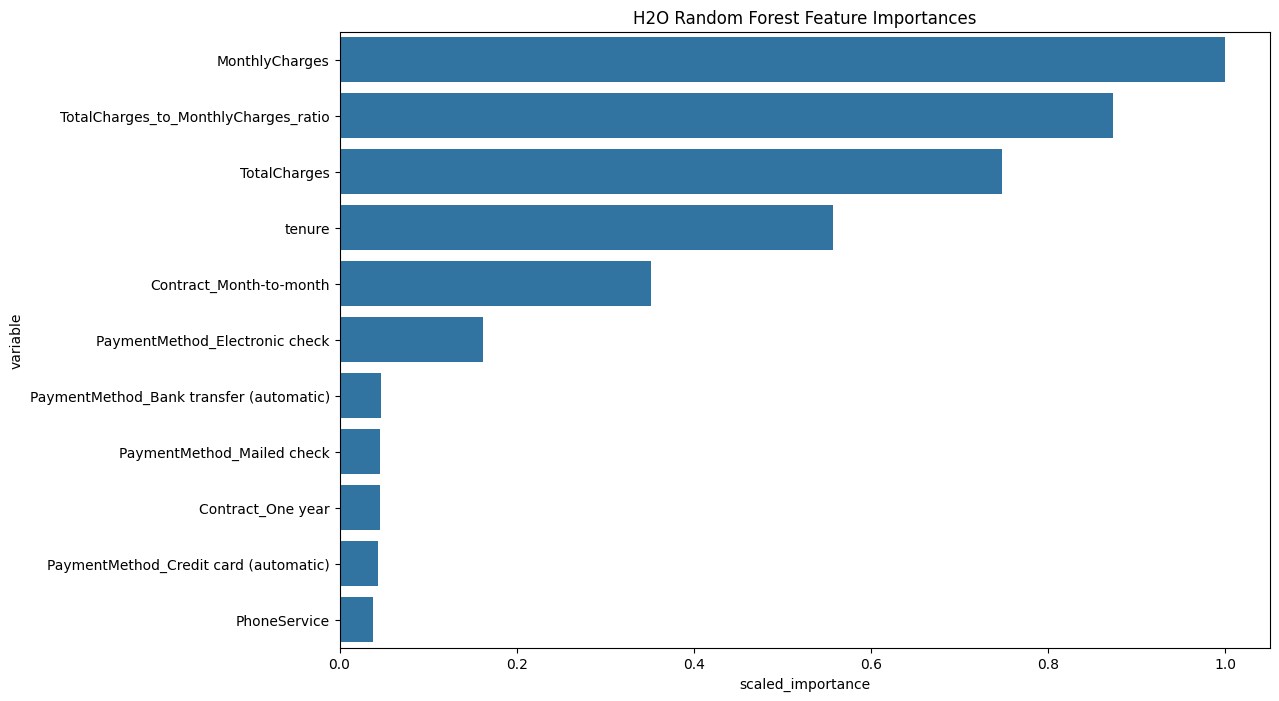

In [22]:
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_h2o.varimp(use_pandas=True)['scaled_importance'], y=rf_h2o.varimp(use_pandas=True)['variable'])
plt.title("H2O Random Forest Feature Importances")
plt.show()

## Hyperparameter tuning for h2o RF

In [26]:
hyper_params = {'ntrees': [50, 100, 200],'max_depth': [3, 5, 10, 20]}

search_criteria = {'strategy': "Cartesian"}

grid = h2o.grid.H2OGridSearch(model=H2ORandomForestEstimator, grid_id='rf_grid', hyper_params=hyper_params, search_criteria=search_criteria)

grid.train(x=hf.columns[:-1], y="Churn", training_frame=train)

drf Grid Build progress: |

███████████████████████████████████████████████████████| (done) 100%


,max_depth,ntrees,model_ids,residual_deviance
,5,50.0,rf_grid_model_10,0.1378149
,5,200.0,rf_grid_model_7,0.1378321
,5,50.0,rf_grid_model_1,0.1379116
,5,200.0,rf_grid_model_16,0.1380107
,5,100.0,rf_grid_model_13,0.1380709
,5,100.0,rf_grid_model_4,0.1381417
,5,50.0,rf_grid_model_22,0.1384661
,5,100.0,rf_grid_model_25,0.1384701
,5,200.0,rf_grid_model_28,0.1386376
,10,200.0,rf_grid_model_8,0.1401909


## Best hyperparameter

In [27]:
best_rf_h2o = grid.models[0]
best_rf_h2o

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_grid_model_10


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          22563                  5            5            5             29            32            31.24

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.13781488588206756
RMSE: 0.3712342735821513
MAE: 0.2788963132837725
RMSLE: 0.2602743165199784
Mean Residual Deviance: 0.13781488588206756

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2024-02-12 01:31:57  0.050 sec   0.0                nan                  nan                  nan
     2024-02-12 01:31:57  0.083 sec   1.0                0.3738466452376305   0.2766159701287137   0.13976131415543075
     2024-02-12 01:31:57  0.097 sec   2.0                0.3758367230594093   0.2771066727540383   0.14125324240003512
     2024-02-12 01:31:57  0.112 sec   3.0                0.3738767737866765   0.27557006541104856  0.13978384197713367
     2024-02-12 01:31:57  0.125 sec   4.0                0.3745703666395875   0.27647324328029943  0.140302959564515
     2024-02-12 01:31:57  0.139 sec   5.0                0.37629672620846083  0.2774631770522253   0.14159922615520534
     2024-02-12 01:31:57  0.152 sec   6.0                0.3752783792530109   0.2767983291039734   0.14083386193476666
     2024-02-12 01:31:57  0.163 sec   7.0                0.37484293332560986  0.2769982555564671   0.14050722466414758
     2024-02-12 01:31:57  0.177 sec   8.0                0.37521236000333935  0.27808066706661977  0.14078431509927553
     2024-02-12 01:31:57  0.190 sec   9.0                0.37477845128768894  0.2779314124674052   0.14045888754959862
---  ---                  ---         ---                ---                  ---                  ---
     2024-02-12 01:31:57  0.476 sec   41.0               0.3711076247558793   0.2786895663566569   0.1377208691519505
     2024-02-12 01:31:57  0.484 sec   42.0               0.37119114742074927  0.2787229389099004   0.13778286792353242
     2024-02-12 01:31:57  0.492 sec   43.0               0.3713079977330354   0.27892082298783216  0.13786962918051585
     2024-02-12 01:31:57  0.499 sec   44.0               0.3712919054350987   0.2789643131947148   0.13785767904162627
     2024-02-12 01:31:57  0.506 sec   45.0               0.3712537644862379   0.27896472457303206  0.13782935764520302
     2024-02-12 01:31:57  0.514 sec   46.0               0.37128502102701155  0.27892863578494576  0.1378525668390284
     2024-02-12 01:31:57  0.521 sec   47.0               0.37132178195460913  0.27895574903889897  0.13787986575394628
     2024-02-12 01:31:57  0.528 sec   48.0               0.37131847148137587  0.27899213266293826  0.13787740726326536
     2024-02-12 01:31:57  0.536 sec   49.0               0.3713034282264283   0.27895589944842775  0.1378662358126984
     2024-02-12 01:31:57  0.545 sec   50.0               0.3712342735821513   0.2788963132837725   0.13781488588206756
[51 rows x 7 columns]


Variable Importances: 
variable                              relative_importance    scaled_importance    percentage
------------------------------------  ---------------------  -------------------  ------------
Month-to-month                        3728.98                1                    0.28983
MonthlyCharges_to_TotalCharges_Ratio  2302.27                0.617399             0.178941
Electronic check                      1454.53                0.39006          

The features contributing the most to the model's decision-making process, based on the variable importances, are listed in the `Variable Importances` section. The top features along with their relative importance:

    Month-to-month: 289.83%
    MonthlyCharges_to_TotalCharges_Ratio: 178.94%
    Electronic check: 113.05%
    tenure: 110.89%
    MonthlyCharges_log: 87.00%
    TotalCharges_Tenure_Ratio: 83.38%
    TotalCharges: 70.39%
    MonthlyCharges: 56.94%
    One year: 5.58%
    Mailed check: 2.80%
    Credit card (automatic): 0.68%
    Bank transfer (automatic): 0.52%

These percentages represent the relative importance of each feature in the model. Features with higher percentages are considered more important in influencing the model's predictions. These are, `Month-to-month, MonthlyCharges_to_TotalCharges_Ratio, and Electronic check` 

## Evaluate DT model performance

In [28]:

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

print("Evaluation of Decision Tree Model:")
evaluate_model(dt_model_tuned, X_test, y_test)


Evaluation of Decision Tree Model:
Accuracy: 0.7871, Precision: 0.6763, Recall: 0.3753, F1 Score: 0.4828


Accuracy (0.7871) - The model achieves an accuracy of approximately 78.71%, indicating that 78.71% of the predictions are correct.

Precision (0.6763) - A precision of 0.6763 suggests that around 67.63% of the instances predicted as positive by the model are indeed positive.

Recall (0.3753) - It measures the model's ability to capture all the positive instances. A recall of 0.3753 means that the model is able to recall or identify approximately 37.53% of the actual positive instances.

F1 Score (0.4828) -  An F1 score of 0.4828 indicates a reasonable balance between precision and recall for the model.

## Summary

In this analysis, we began by preprocessing the churn data, including the creation of dummy variables for categorical features and factorization of selected columns. We trained decision tree and H2o random forest model, initially evaluating the DT performance using accuracy, precision, recall, and F1 score metrics. The decision tree model was further refined through hyperparameter tuning using GridSearchCV to optimize the max_depth parameter. 

The dataset is split into training and test sets. Subsequently, a Random Forest model is trained on the original data using H2O. Feature importances are visualized for the H2O Random Forest model. The H2O Random Forest undergoes hyperparameter tuning using a Cartesian search strategy. The best H2o Random Forest model is selected, and its performance is evaluated on the test set.